<a href="https://colab.research.google.com/github/gibsonx/tf_skeleton/blob/master/tf_keypoint_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!git clone https://github.com/gibsonx/tf_skeleton.git

In [3]:
#!pip install -r /content/tf_skeleton/requirements.txt > /dev/null

In [4]:
from pycocotools.coco import COCO
import numpy as np
import os.path
from typing import Any, Callable, List, Optional, Tuple
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, json, cv2, numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

import tensorflow as tf

from keras.models import Sequential

from keras.layers import (
    Flatten,
    Dense,
    Dropout,
    Conv2D,
    LeakyReLU,
    BatchNormalization,
    MaxPool2D,
    GlobalAveragePooling2D,
)
from imgaug import augmenters as iaa
import imgaug as ia
import imageio
from keras.applications import ResNet50
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage
import math

In [5]:
train_img_dir="/content/drive/MyDrive/Dataset/aspine20230930/image_train"
val_img_dir="/content/drive/MyDrive/Dataset/aspine20230930/image_val"
val_annotations_file="/content/drive/MyDrive/Dataset/aspine20230930/annotations/person_keypoints_Validation.json"
train_annotations_file="/content/drive/MyDrive/Dataset/aspine20230930/annotations/person_keypoints_Train.json"

In [6]:
class DataframeMaker():

  def __init__(self,img_path,annotations_file, img_height, img_width):
      self.img_path = img_path
      self.coco = COCO(annotations_file)
      self.imgIds = self.coco.getImgIds()
      self.dataframe = None
      self.__coco_build__()
      self.img_height = img_height
      self.img_width = img_width
      if self.img_width and self.img_height:
          self.resize_dataset()
          print ("image size has been set to %d x %d" % (self.img_height, self.img_width))
      else:
          print ("image keeps as original size")

  def __coco_build__(self):
      """
      read annotation and build dataframe
      :return:
      """
      kps_metrix = []

      for id in self.imgIds:

        # load a image
        img = self.coco.loadImgs(id)[0]
        imgPath = img['file_name']

        ann=self.coco.loadAnns(self.coco.getAnnIds(imgIds=img['id']))

        keypoints_original = [[list(a) for a in zip(*[iter(ann[0]['keypoints'])]*3)]]

        kps_row = []
        for kp in keypoints_original:
            for el in kp:
                kps_row.extend(el[0:2])
        kps_row.append(imgPath)

        kps_metrix.append(kps_row)

      df = pd.DataFrame(kps_metrix)

      self.dataframe = df

  def resize_dataset(self):
    """
    :param img_height:
    :param img_width:
    :return:
    """
    ts_kps_metrix = []
    ts_image_list = []

    for index, row in self.dataframe.iterrows():


      image = row[-1:].item()
      fullImgPath = os.path.join(self.img_path,image)
      open_cv_image = np.array(Image.open(fullImgPath))

      annotations = row[:32]
      converted_keypoints = [list(a) for a in zip(*[iter(annotations)]*2)]

      kps = [Keypoint(x=coodination[0], y=coodination[1]) for coodination in converted_keypoints]
      kpsoi = KeypointsOnImage(kps, shape=open_cv_image.shape)

      ia.seed(1)

      seq = iaa.Sequential([
          iaa.Resize({"height": self.img_height , "width": self.img_width})
      ])

      image_aug, kpsoi_aug = seq(image=open_cv_image, keypoints=kpsoi)

      ts_kps_row = []

      for i in range(len(kpsoi_aug.keypoints)):
          after = kpsoi_aug.keypoints[i]
          ts_kps_row.extend([after.x,after.y])

      ts_kps_metrix.append(ts_kps_row)
      ts_image_list.append(image_aug)

    df = pd.DataFrame(ts_kps_metrix)

    df['image'] = ts_image_list

    self.dataframe = df

class DataGenerator(tf.keras.utils.Sequence):

  def __init__(self, dataframe, batch_size, arguement = False):
      self.df = dataframe
      self.batch_size = batch_size
      self.argument = arguement

  def __len__(self):
      return math.ceil(len(self.df) / self.batch_size)

  def __getitem__(self, idx):
      low = idx * self.batch_size
      # Cap upper bound at array length; the last batch may be smaller
      # if the total number of items is not a multiple of batch size.
      high = min(low + self.batch_size, len(self.df))
      images = self.df.loc[low:high,'image']
      annotations = self.df.loc[low:high,:31]
      if self.argument:
          return self.data_arguement(images,annotations)
      else:
          return np.stack(images), annotations

  def data_arguement(self, images, annotations):

      ia.seed(3)
      seq = iaa.Sequential([
                      iaa.SomeOf((0, 3), [
                          iaa.Affine(scale={"x": (0.8, 1), "y": (0.8, 1)},
                              rotate=(-10,10),
                              shear=(-8,8)
                              ),
                      iaa.LinearContrast((0.4, 1.6)),
                      iaa.GaussianBlur((0, 3.0)),
                      ])
                  ])

      images_aug, points_aug = seq(images=images, keypoints=self.kpslist_to_tuple(annotations))
      kps_list = self.kpstuple_to_list(points_aug)

      return np.stack(images_aug), np.stack(kps_list)

  def kpslist_to_tuple(self,annotations):
      kpstuple = []

      for index, row in annotations.iterrows():
          converted_keypoints = [list(a) for a in zip(*[iter(row)]*2)]
          kps = [Keypoint(x=coodination[0], y=coodination[1]) for coodination in converted_keypoints]
          kpstuple.append(kps)

      return kpstuple

  def kpstuple_to_list(self,kps_tuple):
      kpslist = []

      for kpsoi in kps_tuple:
          ts_kps_row = []
          for i in range(len(kpsoi)):
              # print(kpsoi_aug[i].is_out_of_image(image=images_aug[i]))
              ts_kps_row.extend([kpsoi[i].x,kpsoi[i].y])
          kpslist.append(ts_kps_row)

      return kpslist

In [7]:
height = 1000
width = 560

val_df = DataframeMaker(val_img_dir,val_annotations_file,1000,560)
train_df = DataframeMaker(train_img_dir,train_annotations_file,1000,560)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
image size has been set to 1000 x 560
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
image size has been set to 1000 x 560


In [8]:
batch_size=12

val_generator = DataGenerator(val_df.dataframe,batch_size,False)
train_generator = DataGenerator(train_df.dataframe,batch_size,True)

In [9]:
def show_image(image, kps, image_path):

    fullImgPath = os.path.join(image_path,image)
    open_cv_image = np.array(Image.open(fullImgPath))
    converted_keypoints = [list(a) for a in zip(*[iter(kps)]*2)]

    kps = [Keypoint(x=coodination[0], y=coodination[1]) for coodination in converted_keypoints]

    kpsoi = KeypointsOnImage(kps, shape=open_cv_image.shape)

    image_with_kps = kpsoi.draw_on_image(open_cv_image, size=15)

    plt.imshow(image_with_kps)

def show_tran_image(image, kps):

    open_cv_image = np.array(image)
    converted_keypoints = [list(a) for a in zip(*[iter(kps)]*2)]

    kps = [Keypoint(x=coodination[0], y=coodination[1]) for coodination in converted_keypoints]

    kpsoi = KeypointsOnImage(kps, shape=open_cv_image.shape)

    image_with_kps = kpsoi.draw_on_image(open_cv_image, size=15)

    plt.imshow(image_with_kps)

Visualize a simple image

Validation Dataset Sample

29


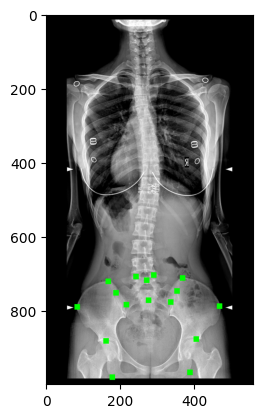

In [10]:
rand_number = np.random.randint(0,len(val_df.dataframe))
print(rand_number)
n = rand_number
X, Y = val_df.dataframe.loc[n][-1:].item(),val_df.dataframe.loc[n][0:32],
show_tran_image(X,Y)


Train Dataset Sample

In [11]:
X_batch, y_batch= next(train_generator.__iter__())
y_batch.shape
# rand_number = np.random.randint(0,batch_size)
# print(rand_number)
# n = rand_number
# Y, X = y_batch[n-1][0:32], X_batch[n-1],
# show_tran_image(X,Y)

(13, 32)

In [12]:
X_batch, y_batch= next(val_generator.__iter__())
y_batch.shape

(13, 32)

In [13]:
model = tf.keras.models.Sequential()
pretrained_model = ResNet50(input_shape=(height,width,3), include_top=False)
pretrained_model.trainable = True

model.add(Conv2D(3, (1,1), padding='same', input_shape=(height,width,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1000, 560, 3)      12        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1000, 560, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 32, 18, 2048)      23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [14]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])

In [18]:
epoch_num = 50

checkpoint_path = "/content/drive/MyDrive/Dataset/aspine20231006.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model.load_weights(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                          save_freq=5,
                          save_weights_only=True,
                          verbose=1)

history = model.fit_generator(generator=train_generator,
                    validation_data=val_generator,
                    epochs=epoch_num,
                    callbacks=[cp_callback])


Epoch 1/50


<ipython-input-18-35f600687148>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


 4/16 [======>.......................] - ETA: 18s - loss: 1849.6830 - mae: 33.5913
Epoch 1: saving model to /content/drive/MyDrive/Dataset/aspine20231006.ckpt
 9/16 [===============>..............] - ETA: 11s - loss: 1804.3624 - mae: 32.9719
Epoch 1: saving model to /content/drive/MyDrive/Dataset/aspine20231006.ckpt
14/16 [=========================>....] - ETA: 3s - loss: 1809.0012 - mae: 33.1144
Epoch 1: saving model to /content/drive/MyDrive/Dataset/aspine20231006.ckpt
16/16 [==============================] - 34s 2s/step - loss: 1820.9464 - mae: 33.2994 - val_loss: 62746.7383 - val_mae: 229.5874
Epoch 2/50
 3/16 [====>.........................] - ETA: 20s - loss: 2067.4829 - mae: 35.3293
Epoch 2: saving model to /content/drive/MyDrive/Dataset/aspine20231006.ckpt
 8/16 [==============>...............] - ETA: 14s - loss: 1891.0990 - mae: 34.2499
Epoch 2: saving model to /content/drive/MyDrive/Dataset/aspine20231006.ckpt
13/16 [=======================>......] - ETA: 5s - loss: 1911.6692

KeyboardInterrupt: ignored

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
X_batch, y_batch= next(val_generator.__iter__())
predictions = model.predict(X_batch)

In [ ]:
index = np.random.randint(0,len(X_batch))
X, Y = X_batch[index], predictions[index]
show_tran_image(X,Y)